# Project: Gradients and Solvers

## Machine Learning, Winter 2017

### Name: Buzzy, Alex, Jocelyn, Kevin

In this project, you'll perform the following tasks:

1. [Explore gradients and contour plots](#Gradients-and-Contour-Plots),
2. [Define a `Variable` class](#The-Variable-class) which is used to compute the gradient of an "arbitrary" function,
3. [Test out your `Variable` class](#A-basic-test-of-your-Variable-class) by plotting some more gradients on contour plots, and 
4. [Build a `LogisticRegression` class](#The-LogisticRegression-class) using your `Variable` class.

In [26]:
# Standard import statements:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
import time

from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

plt.style.use("ggplot")

## Gradients and Contour Plots

Let's begin by understanding how contour plots work.  These are 2D representations of functions of two variables (what some people might call "3D functions").  You may be familiar with [contour maps](http://sitesmedia.s3.amazonaws.com/creekconnections/files/2014/09/topomap.jpg); a contour map is simply a contour plot of the function 

$$f(\text{lattitude}, \text{longitude}) = \left<\text{height of the Earth's surface above sea level at that point}\right>.$$ 

More generally, the contours in a plot are the paths of same height.  Thus, traveling perpendicularly to a contour means traveling "straight up or down the mountain".  Here's a first attempt at making a contour plot for a function which somewhat resembles the top of a mountain:

Exception was raised: 
TypeError: Input z must be a 2D array.


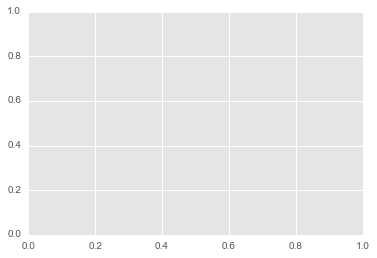

In [27]:
def f(x,y):
    return 1.2 - 0.2*x**2 - 0.3*y**2 + 0.1 * x * y - 0.25 * x

x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)

# maybe a first guess is:
z = f(x,y)

try:
    plt.contour(x, y, z);
except Exception as e:
    print("Exception was raised: \n", type(e).__name__, ": ", e, sep='')

That doesn't work, because this only plugs values into $f$ which are on the *diagonal*, that is, those values in the $xy$-plane where $x=y$.  In order to make this work, we need a function value over every point in our grid, i.e. every pair of $x$- and $y$-values in the square.  This is why the value for z must be 2D, because its indices `i` and `j` are the indices of its $x$- and $y$-values of its point.  That is, `z[i,j] = f(x[i], y[j])`.

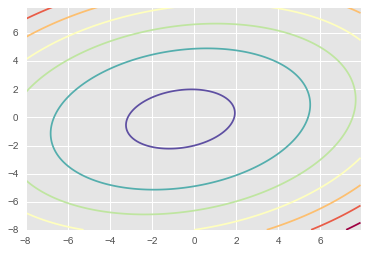

In [28]:
# Better:
z = np.array([[f(x[i],y[j]) for i in range(x.shape[0])] for j in range(y.shape[0])])
### Make sure you understand the above line!

try:
    plt.contour(x, y, z, cmap='Spectral');
except Exception as e:
    print(e)

That works, but that line defining `z` sure was a slog.  This is where the helper function `np.meshgrid` comes into play:

In [29]:
X, Y = np.meshgrid(x, y)
Z = f(X,Y)

# Convenience for printing 
iters = [('x', x), ('X', X), ('y', y), ('Y', Y), ('z', z) , ('Z', Z)]

for name, var in iters:
    print("The shape of {} is {}".format(name, var.shape))

if (z == Z).all():
    print("\nThese ways work the same")

The shape of x is (160,)
The shape of X is (160, 160)
The shape of y is (160,)
The shape of Y is (160, 160)
The shape of z is (160, 160)
The shape of Z is (160, 160)


So `np.meshgrid` is used to build this `Z` (which is the same as our manually-built `z`).  But what are `X` and `Y`?

In [30]:
## Make sure you understand what the following code is doing!  It will help with understanding X and Y.

for name, var in iters[:4]:
    try:
        snipped = var[:6, :6]
    except:
        snipped = var[:6]
    print('{}:\n{}'.format(name, snipped), end='\n\n')

x:
[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]

X:
[[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]
 [-8.  -7.9 -7.8 -7.7 -7.6 -7.5]]

y:
[-8.  -7.9 -7.8 -7.7 -7.6 -7.5]

Y:
[[-8.  -8.  -8.  -8.  -8.  -8. ]
 [-7.9 -7.9 -7.9 -7.9 -7.9 -7.9]
 [-7.8 -7.8 -7.8 -7.8 -7.8 -7.8]
 [-7.7 -7.7 -7.7 -7.7 -7.7 -7.7]
 [-7.6 -7.6 -7.6 -7.6 -7.6 -7.6]
 [-7.5 -7.5 -7.5 -7.5 -7.5 -7.5]]



<div style="background-color: #EFDDFF; ">
<p>Describe what you're seeing:</p>
</div>

The `X` array is created by copying the `x` array as many times as the length of the `y` array. This forms a 2D array with identical rows. The `Y` array is created by making a new row for each value in the `y` array with the same length as the original `x` array. This forms a 2D array with identical columns. The grids are then cut so only 6 rows and columns are visible.

In order to make the contour map, it is necessary to have a 2d array of every point. If X and Y are combined using f, then we get an array of the output at every point. If x and y are combinde using f, we only get a 1d output along the diagonal. 

Okay, so now that we know how to plot contour plots of functions of 2 variables, let's explore adding some **gradients** to the plot.  First, a helper function, taken from earlier notes from out class.

In [31]:
def draw_arrow(a, b, c, d, ax=None):
    """ Draw an arrow on a plot.
    
    params:
        a, b -- coordinates of the base of the arrow
        c, d -- vector corresponding to the arrow (starting at the origin)
        ax   -- the matplotlib Axes object on which to draw the arrow.  If none, set to current Axes object.
    """
    ax = ax or plt.gca()
    v_0 = np.array([a,b])
    v_1 = np.array([c,d]) + v_0
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    color='k')
    plt.annotate('', v_1, v_0, arrowprops=arrowprops)

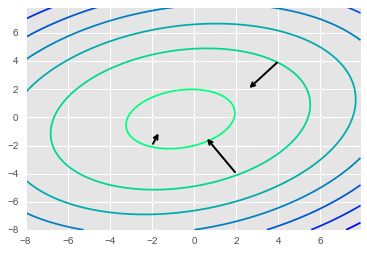

In [32]:
# Plot the contour plot as well as some gradient vectors
x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)

X, Y = np.meshgrid(x,y)
Z = f(X,Y)

plt.contour(x, y, Z, cmap='winter')

# Draw some gradients
draw_arrow(2, -4, -1.45,  2.6)
draw_arrow(-2, -2, 0.35, 1)
draw_arrow(4, 4, -1.45, -2)

<div style="background-color: #EFDDFF; ">
<p> Okay, so now here's your task. The gradient of this function is $\nabla f(x,y) = \left<-.4 x + .1 y - .25, -.6 y + .1 x\right>$.  Create a function `draw_gradient` that, given a point $(x,y)$, draws the gradient of $f$ at that point.  Then, recreate the plot above so that your `draw_gradient` method gets called for a handful of randomly-generated points (so that you can rerun the cell and get a new handful of points each time).  You may decide to change your contour plot to a `contourf` plot, which would fill the lines in with a solid shape.</p>
</div>

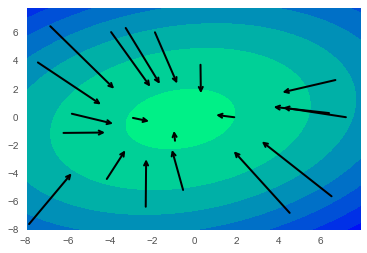

In [33]:
# Good luck!
import random
def draw_gradient(x,y):
    del_f = (-.4*x + 0.1*y-0.25,-0.6*y+0.1*x) #formula for the gradient of the equation
    draw_arrow(x, y, del_f[0],  del_f[1])
x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)
X, Y = np.meshgrid(x,y)
Z = f(X,Y)

plt.contourf(x, y, Z, cmap='winter')
for i in range(20):
    r1 = random.randint(0,len(x)-1) #pick random point r1 for x
    r2 = random.randint(0,len(y)-1) #pick random point r2 for y
    p1 = x[r1]
    p2 = y[r2]
    draw_gradient(p1,p2)

<div style="background-color: #EFDFDF; ">

<h3> Rules for Gradients:</h3>

<p>In a multivariable calculus class, you would study and possibly even prove these statements.  For us, we'll take them as our programming requirements.  **Do not feel like you need to memorize these for my class. I will never ask you to compute the gradient of a function by hand on a test.**</p>

<ul>
<li> If $x_i$ is the $i^{\text{th}}$ independent variable, then $\nabla x_i = \left<0,\ldots,0,1,0,\ldots, 0\right>$, where the $1$ is in the $i^{\text{th}}$ slot.</li>
<li> The gradient is **linear**: </li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = w_1+w_2$, then $\nabla f = \nabla w_1 + \nabla w_2$, and </li>
 <li> If $f(x_1, \ldots, x_p) = c \cdot w$, then $\nabla f = c \cdot \nabla w$.</li>
 <li> (As an extension of the first point: if $f(x_1, \ldots, x_p) = \sum_{i=1}^n w_i$, then $\nabla f = \sum_{i=1}^n\nabla w_i$.)</li>
 </ul>
<li> The gradient has a **power rule**: </li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = w^n$ then $\nabla f = n w^{n-1} \cdot \nabla w$, </li>
 </ul>
<li> The gradient has a **product rule**: </li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = w_1\cdot w_2$ then $\nabla f = w_1 \cdot \nabla w_2 + w_2 \cdot \nabla w_1$,</li>
 </ul>
<li> The gradient does have a *difference rule* and a *quotient rule*, but you can just define yours using the facts that $w_1 - w_2 = w_1 + (-1) \cdot w_2$ and $\dfrac{w_1}{w_2} = w_1 \cdot (w_2)^{-1}$, respectively.</li>
<li> The gradient has a **chain rule**, which manifests itself in the following ways (the only ones we'll need):</li>
 <ul>
 <li> If $f(x_1, \ldots, x_p) = \exp(w)$ then $\nabla f = \exp(w) \cdot \nabla w$,</li>
 <li> If $f(x_1, \ldots, x_p) = \ln(w)$ then $\nabla f = \frac{1}{w} \cdot \nabla w$, </li>
 <li> There are lots of others, but I don't think we'll need them for now. </li>
 </ul>
</ul>
 
 </div>

## The `Variable` class

Your main task in the project is to make a `Variable` class.  The `Variable` class is a node in the computational graph.  It should have the following attributes and methods:

* a class attribute `wengert` which is a list that keeps track of all the Variable objects in the order of a Wengert list.  There are fancy technical definitions and requirements of such a list, but for you, it should just be a list that holds all your `Variable` objects (so in the constructor, you should append `self` to the list).  You may get less milage out of this list than I did, depending on your implimentation, but I found it helpful to have it.
 * a class method which resets the wengert list to an empty list.  This allows you to redefine the expression if you mess up. Google `@staticmethod` to see the notation.
* an attribute `inputs`, a list that records which inputs the current `Variable` objects takes.  This could highly leverage your wengert list.
* an `__init__` method,
* an `eval_` method that allows you to evaluate the variable at a given value of the primitive variables,
* a `grad` method that will compute return the gradient at a given value,
* appropriate methods/functionality to calculate the gradients and function evaluation for all the gradients defined above:

As an example, if I were to say:

```
>>> x = Variable()
>>> y = Variable()
>>> z = x + y
```

This will create a new `Variable` class for `z`, and initialize it appropriately, and give it the ability to take its gradient.  The way we can implement this is by defining a *magic* method called `__add__`.  Magic methods in Python are what give it such a great functional API.  Here's an example `__add__` method, based on how I set up my constructor.  Yours might be a little bit different:

```
    def __add__(self, other):
        """ Defines the functionality of the `+` operator. """
        if isinstance(other, (int, float)):
            """ The derivative of a constant is zero. """
            return Variable(inputs=[self],
                            eval_=lambda *values: other + self.eval_(*values), 
                            grad= self.grad)
        elif isinstance(other, Variable):
            """ The differential operator is linear. """
            return Variable(inputs=[self, other],
                            eval_=lambda *values: self.eval_(*values) + other.eval_(*values),
                            grad= lambda *values: self.grad(*values) + other.grad(*values))
        else:
            return NotImplemented
```

See [this link](http://www.diveintopython3.net/special-method-names.html#acts-like-number) to learn about the magic methods you will need to implement.

The theory here is that you create the "ugly" `x.add(y)`-ish code once and only once, and then when you use the code later it's much more readable: `x + y`.  You'll need to do something like this for all the operations discussed above in the [gradients section](#-Rules-for-Gradients:).  The exception is for functions like `exp` and `log` (and if I wanted you to do other things, like `sin`, `cos`, `tan`, etc.).  Those will need to be class methods.  They should still return a new `Variable` object.  See below for the API that they should support.

Other methods you need to implement:

* While you do need to have an `eval_` method, if you also implement the `__call__` method (to just call `eval_`) then you can replace code of the form `w.eval_(4, 2, 8.5)` with `w(4, 2, 8.5)`, which is both cleaner and looks like function notation (which is desirable because the `w`'s really can be thought of as functions of the independent variables).
* You should implement the `__repr__` method so that you can print out your variables.  It would be especially nice if printing out a `Variable` object gave you a graph traversal of its `inputs`, similar to the `DecisionTree` class that you made before break.  It's okay here if it looks like a tree, *i.e.* nodes get repeated.  It would be a bit too much work to make the true graph visual happen, I think.
* You should implement methods like `__radd__` and `__rmul__` that give your `__add__` and `__mul__` method more functionality.  You shouldn't implement in-place methods like `__iadd__` and `__imul__`, becuase you need to be getting a new `Variable` each time and so *shouldn't* be overriding previous ones.  In fact, virtual bonus points for implementing them to raise a `NotImplementedError`. 

Here are some resources that may help you along the way:
* A good explanation on [Automatic Differentiation](https://pdfs.semanticscholar.org/be3d/17df872d41465dabda2fc9a9a61394658a1a.pdf) (the name of this process).  It's probably much more information than you need.
* There's always [Wikipedia](https://en.wikipedia.org/wiki/Automatic_differentiation).
* Another take on [operator overloading in Python](http://blog.teamtreehouse.com/operator-overloading-python).

## A "complete" collection of uses that demonstrates the API 

```
>>> from Variable import exp, log
>>> x_1 = Variable()
>>> x_2 = Variable()
>>> x_3 = Variable()
>>> z = exp(x_1 + x_2**2) + 3 * log(27 - x_1 * x_2 * x_3)
>>> # Evaluate the function at the point (x_1, x_2, x_3) = (3, 1, 7):
>>> z(3, 1, 7)
<whatever that's equal to>
>>> # Determine the gradient of the function at the point (x_1, x_2, x_3) = (3, 1, 7):
>>> z.grad(3, 1, 7)
<whatever that's equal to>
>>> print(z)
<somewhat attractive, readable printout of the computational graph>
```

## Some thoughts on coding process

* I recommend that you don't actually define the class in a single cell in this notebook.  It's going to get a bit big, and it's going to be difficult to work on it together if it's in a cell on a jupyter notebook.  I believe that a better strategy for designing this class is to have a Python file `variable.py` that contains your `Variable` class, and then just have a cell like this:

#### Acknowledgements: Henry Desai, Lior Hirschfield, Jihoun Im for helping with the printing of the graph

In [53]:
import math
import numpy as np

"""Variable Class defines a node in a computational graph"""
class Variable:
    wengert = []                        #wengert list stores all concurrent variables
    inputs = []                         #stores inputs of the variables
    value = None
    def __init__(self, inputs=None, eval_=None, grad=None, symbol = "End of node", components = [], index = 0):
        self.inputs = inputs
        self.symbol = symbol
        self.components = components
        self.index = index
        if eval_ :
            #Variable is not an input variable
            self.eval_ = eval_
            self.grad = grad
        else:
            #Variable is an input
            Variable.wengert.append(self)
            self.inputIndex = len(Variable.wengert) - 1
            if self.inputIndex >= 0:
                self.eval_ = lambda *values: values[self.inputIndex]
                self.grad = lambda *values: np.array([0 if n!= self.inputIndex else 1 for n in range(len(values))])

    """Resets wengert to empty list so new equation can be run"""
    def clear_wengert():
        Variable.wengert = []
        Variable.inputs = []
        Variable.value = None

    """Exponent function: e to the power of self"""
    def exp(mySelf):
        return Variable(inputs=[mySelf],
                        eval_=lambda *values: math.e** mySelf.eval_(*values),
                        grad= lambda *values: (math.e** mySelf.eval_(*values))*mySelf.grad(*values), 
                        symbol = "exp()",
                        components = [mySelf],
                        index = mySelf.index + 1)  #derivative of e^x is e^x

    """Takes the natural log"""
    def log(mySelf):
        return Variable(inputs=[mySelf],
                        eval_=lambda *values: math.log(mySelf.eval_(*values) + .00000001),
                        grad= lambda *values: 1/mySelf.eval_(*values)*mySelf.grad(*values), 
                        symbol = "ln()",
                        components = [mySelf],
                        index = mySelf.index + 1) #derivative of ln(a) is 1/a
    
    """ Defines the functionality of the `+` operator. """
    def __add__(self, other):
        if isinstance(other, (int, float)):
            """ The derivative of a constant is zero. """
            return Variable(inputs=[self],
                            eval_=lambda *values: other + self.eval_(*values),
                            grad= self.grad, 
                            symbol = "+",
                            components = [self],
                            index = self.index + 1)
        elif isinstance(other, Variable):
            """ The differential operator is linear. """
            return Variable(inputs=[self, other],
                            eval_=lambda *values: self.eval_(*values) + other.eval_(*values),
                            grad= lambda *values: self.grad(*values) + other.grad(*values), 
                            symbol = "+",
                            components = [self, other],
                            index = self.index + 1)
        else:
            return NotImplemented

    """ Defines the functionality of the `-` operator. """
    def __sub__(self, other):
        if isinstance(other, (int, float)):
            """ The derivative of a constant is zero. """
            return Variable(inputs=[self],
                            eval_=lambda *values: other - self.eval_(*values),
                            grad= self.grad, 
                            symbol = "-",
                            components = [self],
                            index = self.index + 1)
        elif isinstance(other, Variable):
            """ The differential operator is linear. """
            return Variable(inputs=[self, other],
                            eval_=lambda *values: self.eval_(*values) - other.eval_(*values),
                            grad= lambda *values: self.grad(*values) - other.grad(*values), 
                            symbol = "-",
                            components = [self, other],
                            index = self.index + 1)
        else:
            return NotImplemented
   
    """ Defines the functionality of the `*` operator. """
    def __mul__(self, other):
        if isinstance(other, (int, float)):
            return Variable(inputs=[self],
                            eval_=lambda *values: other * self.eval_(*values),
                            grad= lambda *values: self.grad(*values) * other, 
                            symbol = "*",
                            components = [self],
                            index = self.index + 1)
        elif isinstance(other, Variable):
            """ The differential operator is linear. """
            return Variable(inputs=[self, other],
                            eval_=lambda *values: self.eval_(*values) * other.eval_(*values),
                            grad= lambda *values: self.grad(*values) * other.eval_(*values) + other.grad(*values)*self.eval_(*values), 
                            symbol = "*",
                            components = [self, other],
                            index = self.index + 1)
        else:
            return NotImplemented

    """Defines the functionality of the `**` operator. """
    def __pow__(self, other):
        if isinstance(other, (int, float)):
            return Variable(inputs=[self],
                            eval_=lambda *values: self.eval_(*values)**other,
                            grad= lambda *values: other*self.eval_(*values)**(other-1)*self.grad(*values), 
                            symbol = "**",
                            components = [self],
                            index = self.index + 1)
        else:
            return NotImplemented

    """ Defines the functionality of the `/` operator. """
    def __truediv__(self,other):
        if isinstance(other, (int, float)):
            """ The derivative of a constant is zero. """
            return Variable(inputs=[self],
                            eval_=lambda *values: other / self.eval_(*values),
                            grad= self.grad, 
                            symbol = "/",
                            components = [self],
                            index = self.index + 1)
        elif isinstance(other, Variable):
            return Variable(inputs=[self, other],
                            eval_=lambda *values: self.eval_(*values) / other.eval_(*values),
                            grad= lambda *values: self.grad(*values) / other.grad(*values),
                            symbol = "/",
                            components = [self, other],
                            index = self.index + 1)
        else:
            return NotImplemented
        
    """ More functionality to __add__ """
    def __radd__(self, other):
        return self.__add__(other)

    """ More functionality to __sub__ """
    def __rsub__(self, other):
        return self.__sub__(other)

    """ More functionality to __div__ """
    def __rtruediv__(self, other):
        return self.__truediv__(other)

    """ More functionality to __mul__ """
    def __rmul__(self, other):
        return self.__mul__(other)

    """Directly call eval_ method on mathematical function rather than using z.eval_(...)"""
    def __call__(self, *values):
        return self.eval_(*values)

    """Prints out computational graph"""
    def __repr__(self, depth=0):
        s=""
        for i in range(depth):
            s += "| "
        s += "W" + str(self.index) + ": " + self.symbol + "\n"
        for i in range(len(self.components)):
            s += self.components[i].__repr__(depth = depth+1)
        
        return s


Components contains the actual python objects (the variables) which make up 'this' variable. 
Self.op is a string containing the operation and self.index is a variable's place in the wengert list.

* Then, when you change something and want to check out how it works, just rerun the above cell.
* This also makes sharing code via something like github a lot easier!
* I highly recommend you begin by making everything other than gradients work, and then add gradients afterward.

### Testing on the equation z = 1.2 - 0.2x^2 - 0.3y^2 + 0.1xy - 0.25x

In [35]:
x = Variable()
y = Variable()
z = 1.2 - 0.2*x**2 - 0.3*y**2 + 0.1 * x * y - 0.25 * x
print(z.grad(4,5)) 
Variable.clear_wengert()
print(z)

[ 1.85 -2.6 ]
W6: -
| W5: +
| | W4: -
| | | W3: -
| | | | W2: *
| | | | | W1: **
| | | | | | W0: End of node
| | | W2: *
| | | | W1: **
| | | | | W0: End of node
| | W2: *
| | | W1: *
| | | | W0: End of node
| | | W0: End of node
| W1: *
| | W0: End of node



Above, we have demonstrated our computational graph. Each different layer is clearly visible and the ends of each of the nodes are marked.

### Testing on the equation z = e^(xy)

In [36]:
x = Variable()
y = Variable()
z = Variable.exp(x*y)
print(z.grad(4,5))
Variable.clear_wengert()

[  2.42582598e+09   1.94066078e+09]


In [37]:
z

W2: exp()
| W1: *
| | W0: End of node
| | W0: End of node

### Testing on the equation z = ln(xy)

In [38]:
x = Variable()
y = Variable()
z = Variable.log(x*y)
print(z.grad(4,5))
Variable.clear_wengert()

[ 0.25  0.2 ]


### Testing on the equation z = x + y^2

In [39]:
x_1 = Variable()
x_2 = Variable()
x_3 = Variable()
z = x_1 + x_2**2
print(z.grad(3,1))
Variable.clear_wengert()

[1 2]


## A basic test of your `Variable` class

Going back up to the contour plots above, create a single cell that defines a random 2-dimensional polynomial in the same form as $f$ above (or to make it more interesting, add higher powers of $x$ and $y$), and then computes its gradient, and plots several randomly chosen gradient vectors.  Remember, gradients should always be pointing "up the mountain", and should be parallel to the contours of your function.

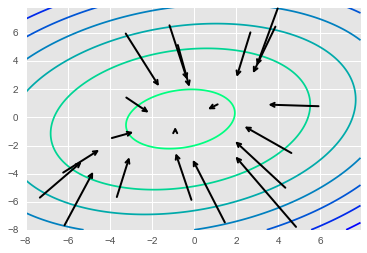

In [40]:
# Good luck!
# Plot the contour plot as well as some gradient vectors
"""draw_gradient takes the point (x,y) and the function z, and uses 
the variable class to compute the gradient of z at the point (x,y)"""
def draw_gradient(x,y, z):
    draw_arrow(x, y, z.grad(x,y)[0], z.grad(x,y)[1])
    Variable.clear_wengert()
    
x = np.arange(-8,8,.1)
y = np.arange(-8,8,.1)

X, Y = np.meshgrid(x,y)
Z = []

#Loop through X and Y and fill in values of Z
for r in range(len(X)):
    ar=[]
    for n in range(len(X[0])):
        a = Variable()
        b = Variable()
        f = (a**2)*(-0.2) - b**2 * 0.3 + a * b * 0.1 - a * 0.25 + 1.2
        num = float(f(X[r][n], Y[r][n]))
        ar.append(num)
        Variable.clear_wengert()
    Z.append(ar)       

#Plot the countour plot
plt.contour(x, y, Z, cmap='winter')

#Select random points and draw the gradients of these random points
for i in range(20):
    r1 = random.randint(0,len(x)-1)
    r2 = random.randint(0,len(y)-1)
    p1 = x[r1]
    p2 = y[r2]
    num = float(f(p1, p2))
    draw_gradient(p1,p2, f)

## The `LogisticRegression` class

Now that you have the class needed for creating a gradient, it's time to put it to use.  Construct a `LogisticRegression` class that serves as a logistic regression model.  It should support the standard Scikit-Learn API:

```
>>> X,y = <some dataset consisting numpy arrays in the standard form>
>>> model = LogisticRegression()
>>> model.fit(X, y)
>>> X_test, y_true = <some test dataset in the standard form>
>>> y_preds = model.predict(X_test)
>>> from sklearn.metrics import accuracy_score
>>> accuracy_score(y_true, y_preds)
```

Use your `Variable` class in the `fit` method of your class (or wherever else seems appropriate).  Remember, you're taking the gradient of the cost function, and the cost function has as its inputs the parameters of your model.  So you should have a `Variable` for every model parameter.  You **don't** need to support multi-class predictions (as in, you can assume your output variable `y` is binary), but you **do** need to support a multidimensional `X` (as in, perhaps my dataset has 7 predictors/features, I want to be able to use your class to fit my data).

**Note**: I recognize that you could just take the partial derivative (or google it), but that's not the point of this project!  The goal is to struggle through both creating and using your `Variable` class.

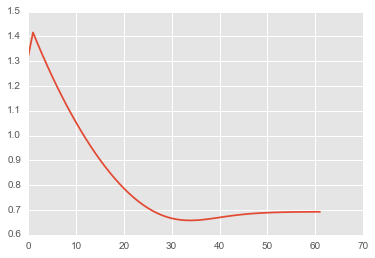

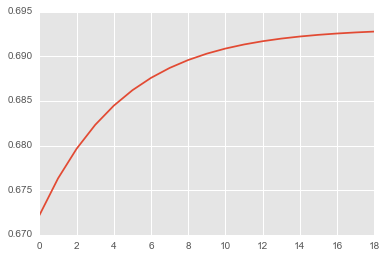

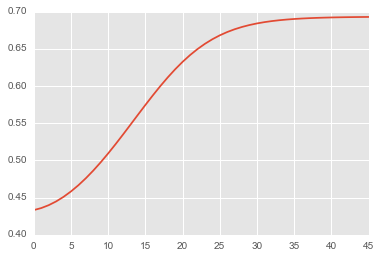

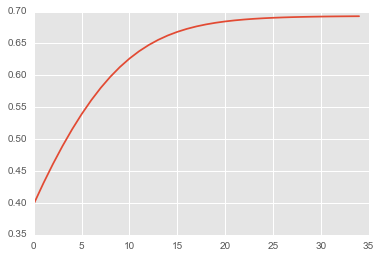

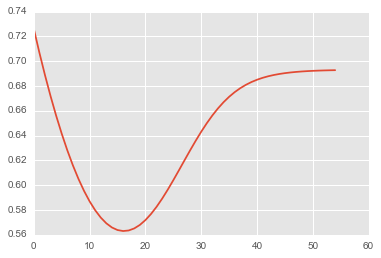

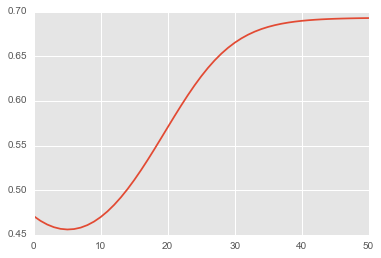

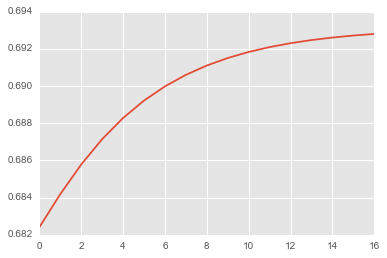

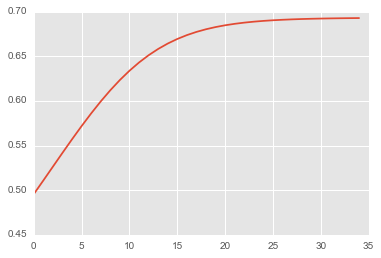

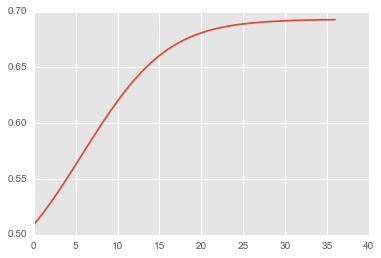

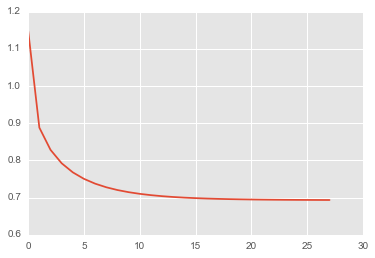

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
100.0 %


In [112]:
# Good luck!
from random import randint, random
from math import e, log
from sklearn.datasets import load_iris
import sys
class LogisticRegression:
    def __init__(self):
        pass
    
    def sigmoid_variable(self, X):
        '''Compute the Sigmoid function with Variable class'''
        return 1/(1.0 + Variable.exp(-1*X))
    
    def sigmoid(self, X):
        '''Compute the Sigmoid function'''
        return 1/(1.0 + e ** (-1.0 * X))
    
        
    def compute_cost_and_gradient(self, X, y):
        Variable.clear_wengert()
        variables = [Variable() for x in range(len(X[0]))]
        
        falseFunc = -1/len(X)*Variable.log(1-self.variable_predict(variables))
        trueFunc = -1/len(X)*Variable.log(self.variable_predict(variables))
        
        """
        Iterate through the datapoints to sum all of the costs and gradients of
        the costs of the given X values.
        """
        costSum = 0
        gradientSum = np.array([0.0 for x in range(len(X[0]))])
        for i in range(len(X)):
            
            # Instead of multiplying by y[i] and (1-y[i]):
            costFunc = trueFunc if y[i] == 1 else falseFunc
            
            # Sum the value and gradient of the cost function at this X:
            gradientSum += costFunc.grad(*X[i])
            costSum += costFunc(*X[i])
            
        return costSum, gradientSum
    
    def fit(self, X, y, theta = .1, numSeeds = 10, verbose=False, plotCosts=False):
        if len(X) == 0 or len(X[0]) == 0:
            return "ERROR!"
        
        """
        Normalize all of the x values:
        """
        self.divConsts = [0 for x in range(len(X[0]))]
        for i in range(len(X)):
            for k in range(len(X[i])):
                # Find max 
                self.divConsts[k] = max(abs(X[i][k]), self.divConsts[k])
        X = X/self.divConsts[k]
        
        """
        Perform gradient descent 'numSeeds' many times to find the weights with
        the lowest cost.
        """
        minCost = float("inf")
        minWeights = []
        for i in range(numSeeds):
            # Equal probability from -1 to 1:
            self.weights = [2*random()-1 for x in range(len(X[0]))]
            
            """
            Iterate indefinity and shift the weights in the opposite direction of the 
            gradient until the cost does not meaningfully change.
            """
            lastCost = float("inf")
            epoch = 0
            costs = []
            while True:
                cost, grad = self.compute_cost_and_gradient(X, y)
                
                #If lowest cost, store weights and new low cost:
                if cost < minCost:
                    minCost = cost
                    minWeights = self.weights[:]
                    
                # For graphing purposes:
                costs.append(cost)
                
                # Shift the weights:
                self.weights -= grad*theta
                
                # Reset if the gradient explodes:
                if len([1 for x in range(len(grad)) if math.isnan(grad[x]) or\
                                       math.isinf(grad[x]) or self.weights[x] > 100 or\
                                       self.weights[x] < -100]) != 0:
                    if verbose:
                        print("GRADIENT EXPLODED. RETRYING WITH SMALLER STEP!")
                        print("new step:", theta)
                        
                    theta /= 1.2
                    self.weights = [2*random()-1 for x in range(len(X[0]))]
                    lastCost = float("inf")
                    epoch = 0
                    continue
                    
                # Print information if verbose:
                if verbose:
                    print("Epoch: ", epoch, " Cost: ", cost)
                    
                # Stop the loop if the cost doesn't change too much:
                if abs(cost - lastCost) < .0001:
                    # Plot the cost against epochs:
                    if plotCosts:
                        plt.plot(costs)
                        plt.show()
                    break
                    
                lastCost = cost
                epoch += 1
                
        self.weights = minWeights
            
    
    def variable_predict(self, variables):
        predictSum = 0
        """
        Sum the weights times their respective X value:
        """
        for x, w in zip(variables, self.weights):
            predictSum += x*w
            
        # 
        logit = self.sigmoid_variable(predictSum)
        return logit
    
    def predict(self, x_test):
        # Convert single dimensional list to two dimensional list:
        if type(x_test[0]) is float or type(x_test[0]) is int:
            x_test = [x_test]
            
        # Normalize the data:
        for i in range(len(x_test)):
            for k in range(len(x_test[i])):
                self.divConsts[k] = max(abs(x_test[i][k]), self.divConsts[k])
        x_test = x_test/self.divConsts
        
        # Create list of predicted values:
        retArr = []
        for i in range(len(x_test)):
            # Sum the product of the weights and X:
            predictedSum = 0
            for x, w in zip(x_test[i], self.weights):
                predictedSum += x*w
                
            # Calculate sigmoid of the sum and append 0 or 1 to retArr:
            logit = self.sigmoid(predictedSum)
            if logit > 0.5:
                retArr.append(1)
            else:
                retArr.append(0)
                
        return retArr
        
        
a=LogisticRegression()

# Iris dataset:
iris = load_iris()
X = iris["data"]
y = iris["target"]
y = [x if x != 2 else 1 for x in y]

# Simple testing data:
#X = np.array([[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]])
#y = np.array([0, 0, 0, 0, 0, 1, 0, 1, 1, 1])

# Fit method to data and predict:
a.fit(X, y, numSeeds = 10, verbose=False, plotCosts=True)
predicted = a.predict(X)

# Print predicted values and accuracy:
print(predicted)
print(np.sum([1 if predicted[i] == y[i] else 0 for i in range(len(y))])/len(predicted)*100, '%')

Yes! Our gradient descent version of Logistic Regression appears to be finding a reasonable minimum. In the case above, we achieved 100% accuracy on the iris dataset without separating our test and training data. However, it appears that shifting the weights in the opposite direction of the calculated cost gradient does not consistently descend to the minimum cost. Instead, as seen in certain graphs above, the weights shift so that the resultant cost is roughly 0.70. We suspect that there is some error we have made in the implementation of our Variable class used to calculate the gradient of the cost function, but, after scouring the code for hours with multiple different datasets, we have been unable to identify the specific issue. 